##TRAINING A MUSIC GENRE GUESSING MODEL USING GZTAN DATABASE

Step -1 Installing libraries required

In [ ]:
!pip install librosa soundfile
!pip install kagglehub

Step-2 Getting the dataset from a good source (with progress bar)

In [ ]:
#setting up kaggle api json file
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#downloading the dataset
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


Step 3 - Checking for bad files (< 30 seconds) and deleting them and doing other checkups

In [ ]:
import os
import librosa
import glob

SAMPLE_RATE = 22050
DURATION = 30
REQUIRED_LENGTH = SAMPLE_RATE * DURATION

dataset_path = os.path.join(path, "Data", "genres_original")

clean_files = []
bad_files = []

for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    if not os.path.isdir(genre_path): continue

    for audio_file in glob.glob(os.path.join(genre_path, "*.wav")):
        try:
            signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
            if len(signal) >= REQUIRED_LENGTH:
                clean_files.append(audio_file)
            else:
                bad_files.append((audio_file, len(signal)))
        except Exception as e:
            bad_files.append((audio_file, str(e)))

/tmp/ipython-input-6-2213919494.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
print(f"Valid 30s files: {len(clean_files)}")
print(f"Invalid or short files: {len(bad_files)}")

for bad in bad_files[:5]:
    print(bad)

Valid 30s files: 990
Invalid or short files: 10
('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00014.wav', 661344)
('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00038.wav', 661408)
('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav', 661408)
('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00051.wav', 661344)
('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav', '')


There are only 10 files, so lets delete them

In [ ]:
deleted_count = 0

for audio_file, reason in bad_files:
    if isinstance(reason, int) and reason < REQUIRED_LENGTH:
        try:
            os.remove(audio_file)
            print(f"✅ Deleted: {audio_file} (length: {reason})")
            deleted_count += 1
            if deleted_count >= 10:
                break
        except Exception as e:
            print(f"Error {audio_file}: {e}")

Error /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00014.wav: [Errno 30] Read-only file system: '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00014.wav'
Error /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00038.wav: [Errno 30] Read-only file system: '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00038.wav'
Error /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav: [Errno 30] Read-only file system: '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav'
Error /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00051.wav: [Errno 30] Read-only file system: '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00051.wav'
Error /kaggle/in

Cant really edit this path!
I will create a "metadata" of myself which will be used during training, and if the metadata excludes these 10 files, they will not be considered for training

In [ ]:
import os
import librosa
import csv
import glob

SAMPLE_RATE = 22050
REQUIRED_LENGTH = SAMPLE_RATE * 30

source_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
output_dir = '/kaggle/working'
output_csv = os.path.join(output_dir, 'clean_metadata.csv')
os.makedirs(output_dir, exist_ok=True)

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filepath', 'genre'])

    for genre in os.listdir(source_path):
        genre_dir = os.path.join(source_path, genre)
        if not os.path.isdir(genre_dir): continue

        for audio_file in glob.glob(os.path.join(genre_dir, '*.wav')):
            try:
                signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
                if len(signal) >= REQUIRED_LENGTH:
                    writer.writerow([audio_file, genre])
            except Exception as e:
                print(f"skip {audio_file}: {e}")

print(f"file saved To: {output_csv}")

/tmp/ipython-input-9-2934333323.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


skip /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
file saved To: /kaggle/working/clean_metadata.csv


In [ ]:
#counting files per genre
import pandas as pd

df = pd.read_csv('/kaggle/working/clean_metadata.csv')

genre_counts = df['genre'].value_counts().sort_index()

print("valid iles per genre:")
print(genre_counts)

valid iles per genre:
genre
blues        100
classical     98
country       97
disco         99
hiphop        98
jazz          99
metal        100
pop          100
reggae       100
rock          99
Name: count, dtype: int64


We are seeing 97-98, after i deleted those 10 files, but it should still train a good model

Step 4 - MFCC extraction

In [ ]:
import pandas as pd
import librosa
import numpy as np

SAMPLE_RATE = 22050
DURATION = 30
REQUIRED_LENGTH = SAMPLE_RATE * DURATION
NUM_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512
EXPECTED_TIME_STEPS = 1292  # For 30s @ hop 512

df = pd.read_csv('/kaggle/working/clean_metadata.csv')

X = []
y = []

for i, row in df.iterrows():
    filepath = row['filepath']
    genre = row['genre']

    try:
        signal, sr = librosa.load(filepath, sr=SAMPLE_RATE)

        if len(signal) >= REQUIRED_LENGTH:
            signal = signal[:REQUIRED_LENGTH]

            mfcc = librosa.feature.mfcc(
                y=signal,
                sr=sr,
                n_mfcc=NUM_MFCC,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )
            mfcc = mfcc.T

            if mfcc.shape[0] == EXPECTED_TIME_STEPS:
                X.append(mfcc)
                y.append(genre)
            else:
                print(f"⚠️ Skipped (wrong shape): {filepath}, shape={mfcc.shape}")

    except Exception as e:
        print(f"failed on {filepath}: {e}")

#convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (num_samples, 1292, 40)
print("y shape:", y.shape)


X shape: (990, 1292, 40)
y shape: (990,)


Step 5 - Labelling, hot encoding and splitting

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_onehot = to_categorical(y_encoded)

X_reshaped = X[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (792, 1292, 40, 1)
y_train shape: (792, 10)


Step 6 - Training using CNN arcitecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense
)

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(1292, 40, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),


    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 genres
])

# compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1290, 38, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1290, 38, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 645, 19, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 645, 19, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 643, 17, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 643, 17, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 321, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 321, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 164352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    21,037,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057,674 (80.33 MB)

 Trainable params: 21,057,482 (80.33 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
#finally, train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.1619 - loss: 49.3669 - val_accuracy: 0.1667 - val_loss: 2.2580
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.2339 - loss: 2.1697 - val_accuracy: 0.1162 - val_loss: 2.2683
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.2565 - loss: 2.0648 - val_accuracy: 0.1667 - val_loss: 2.2459
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.2616 - loss: 1.9959 - val_accuracy: 0.1717 - val_loss: 2.2067
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.2784 - loss: 1.9542 - val_accuracy: 0.1667 - val_loss: 2.1803
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.2400 - loss: 1.9510 - val_accuracy: 0.3586 - val_loss: 2.1775
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.3555 - loss: 1.7607 - val_accuracy: 0.3283 - val_loss: 1.9814
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.2866 - loss: 1.9052 - val_accuracy: 0.3030 - 

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 599ms/step


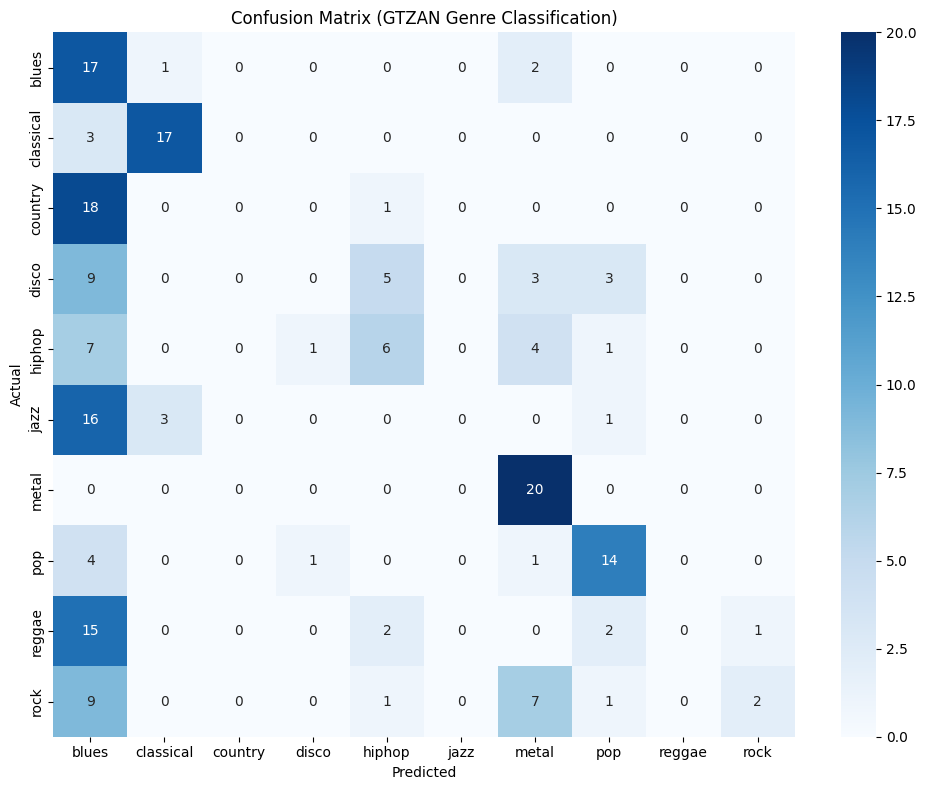

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_probs = model.predict(X_test)

y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

genre_labels = label_encoder.classes_

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_labels,
            yticklabels=genre_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GTZAN Genre Classification)")
plt.tight_layout()
plt.show()

Not so good uptil now 35% accuracy max cap, maybe running 15 more epocs might help a bit

In [ ]:
history2 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=35,
    initial_epoch=20,
    batch_size=32
)

Epoch 21/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.3453 - loss: 1.7264 - val_accuracy: 0.3485 - val_loss: 1.9603
Epoch 22/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.3044 - loss: 1.8306 - val_accuracy: 0.3535 - val_loss: 2.1401
Epoch 23/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.2859 - loss: 1.7892 - val_accuracy: 0.3636 - val_loss: 2.3054
Epoch 24/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.3027 - loss: 1.7902 - val_accuracy: 0.3535 - val_loss: 2.4731
Epoch 25/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.3241 - loss: 1.7591 - val_accuracy: 0.3384 - val_loss: 1.9151
Epoch 26/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.2950 - loss: 1.8161 - val_accuracy: 0.3737 - val_loss: 2.4064
Epoch 27/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.2889 - loss: 1.8441 - val_accuracy: 0.3586 - val_loss: 2.1515
Epoch 28/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.3188 - loss: 1.7060 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step


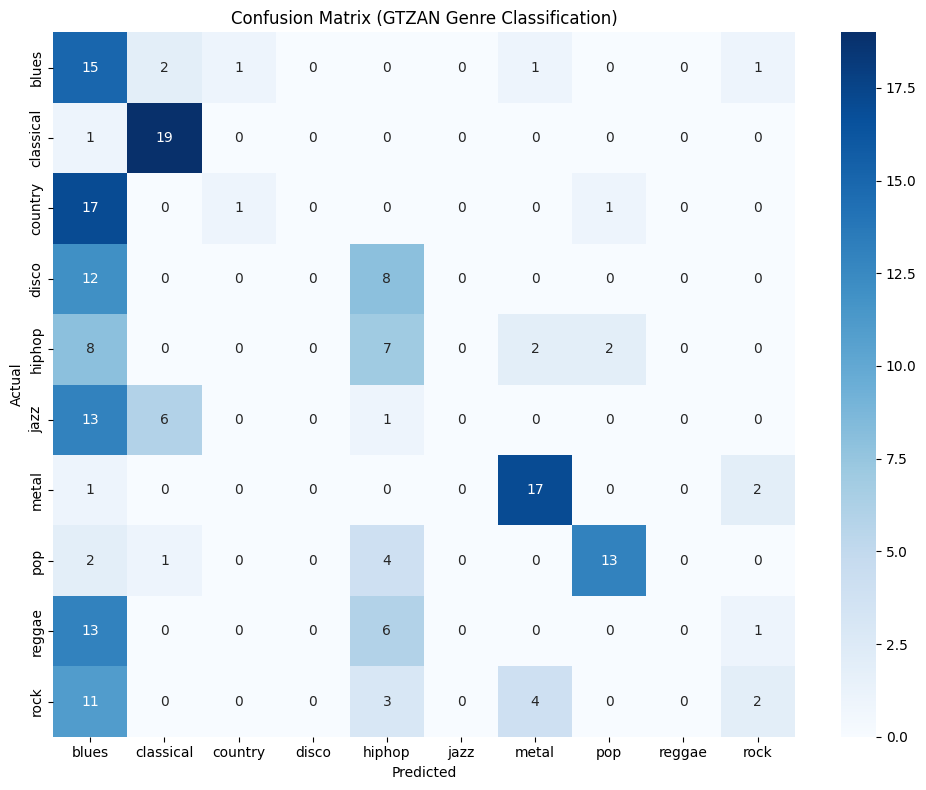

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_probs = model.predict(X_test)

y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

genre_labels = label_encoder.classes_

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_labels,
            yticklabels=genre_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GTZAN Genre Classification)")
plt.tight_layout()
plt.show()

Okay, accuracy still bad after 35 epochs, could be better, ill try training on class weights

Step 7 - Tying training with class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights_array))

print("🔢 Class Weights:")
for i, weight in class_weights.items():
    print(f"{i}: {weight:.3f} ({label_encoder.inverse_transform([i])[0]})")

🔢 Class Weights:
0: 0.990 (blues)
1: 1.015 (classical)
2: 1.015 (country)
3: 1.003 (disco)
4: 1.003 (hiphop)
5: 1.003 (jazz)
6: 0.990 (metal)
7: 0.990 (pop)
8: 0.990 (reggae)
9: 1.003 (rock)


In [ ]:
#train with weights
history_weighted = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.3324 - loss: 1.8737 - val_accuracy: 0.2828 - val_loss: 2.1487
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.2930 - loss: 1.8834 - val_accuracy: 0.2626 - val_loss: 4.3388
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.2522 - loss: 2.3216 - val_accuracy: 0.2879 - val_loss: 2.1254
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.2501 - loss: 1.9534 - val_accuracy: 0.2879 - val_loss: 2.2982
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.2537 - loss: 2.0772 - val_accuracy: 0.2879 - val_loss: 2.0911
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.2613 - loss: 1.9446 - val_accuracy: 0.3081 - val_loss: 2.0847
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.2658 - loss: 1.9342 - val_accuracy: 0.2626 - val_loss: 2.2865
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.2476 - loss: 1.9662 - val_accuracy: 0.2677 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step


<ipython-input-26-1666039365>:25: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


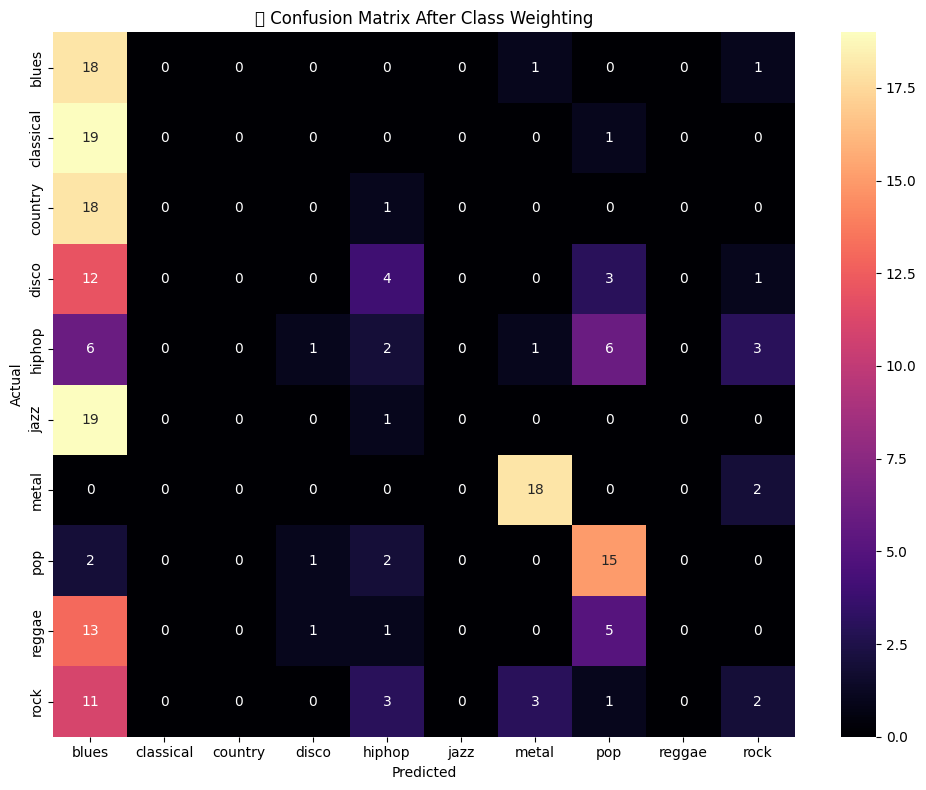

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1️⃣ Predict on test set
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 2️⃣ Get genre label names
genre_labels = label_encoder.classes_

# 3️⃣ Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# 4️⃣ Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=genre_labels,
            yticklabels=genre_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🎵 Confusion Matrix After Class Weighting")
plt.tight_layout()
plt.show()

#TIME TO CHANGE THE APPROACH
I've read that MFC compresss data too much, that leads to poor performance of GZTan, I have read a Medium article online and found out what approach works best for GZTan:
 - Use Mel spectrograms (not MFCC)

 - Slice audio into shorter samples (e.g., 4 s × 6 per track)

 - Train a deep CNN (3×Conv with BatchNorm) on multiple subsamples per epoch

And also got an Optimal Model config! Following it now

Link - https://glenn-viroux.medium.com/creating-a-music-genre-classifier-using-a-convolutional-neural-network-548d06658cee

Step 1 - Reloading my MetaData (because Google Colab reset)

In [ ]:
import pandas as pd

# ✅ Load metadata
meta_df = pd.read_csv("/kaggle/working/clean_metadata.csv")

# 🧐 Inspect top rows and columns
print(meta_df.shape)
print(meta_df.columns)
print(meta_df.head())


(990, 2)
Index(['filepath', 'genre'], dtype='object')
                                            filepath  genre
0  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
1  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
2  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
3  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
4  /kaggle/input/gtzan-dataset-music-genre-classi...  disco


Step 2 - Splitting tracks into 4 sec files

In [ ]:
import numpy as np
import librosa

SR = 22050
SLICE_SEC = 4
SLICE_LEN = SR * SLICE_SEC

clips, labels = [], []

for idx, row in meta_df.iterrows():
    filepath = row['filepath']
    genre = row['genre']
    y, _ = librosa.load(filepath, sr=SR, duration=30)
    for i in range(6):  # up to 6 slices per track
        start = i * SLICE_LEN
        clip = y[start:start + SLICE_LEN]
        if len(clip) == SLICE_LEN:
            clips.append(clip)
            labels.append(genre)

print("Generated clips:", len(clips))

Generated clips: 5940


Step 3 - Convert clips into Mel- spectogram and Normalize

In [ ]:
import numpy as np
import librosa

def clips_to_mel(clips, sr=22050, n_mels=64):
    mel_list = []
    for c in clips:
        m = librosa.feature.melspectrogram(y=c, sr=sr, n_mels=n_mels)
        m_db = librosa.power_to_db(m, ref=np.max)
        mel_list.append(m_db)
    X = np.array(mel_list)[..., np.newaxis]  # shape: (n_clips, 64, t, 1)
    return X

X = clips_to_mel(clips)
print(f"✅ Mel spectrograms shape: {X.shape}")

✅ Mel spectrograms shape: (5940, 64, 173, 1)


In [ ]:
X_norm = np.array([
    (x - np.mean(x)) / (np.std(x) + 1e-8)
    for x in X
])
print("Normalized spectrogram shape:", X_norm.shape)

Normalized spectrogram shape: (5940, 64, 173, 1)


Step 4 - Encoding Label and Splitting

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

print("Classes:", le.classes_)
print("Sample encoded labels:", y_encoded[:10])

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y_encoded, test_size=0.2,
    stratify=y_encoded, random_state=42
)

print(f"Split done – X_train: {X_train.shape}, X_val: {X_val.shape}")

Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Sample encoded labels: [3 3 3 3 3 3 3 3 3 3]
Split done – X_train: (4752, 64, 173, 1), X_val: (1188, 64, 173, 1)


Step 5 - Defining CNN based on the article

In [ ]:
import pandas as pd

meta_df = pd.read_csv("/kaggle/working/clean_metadata.csv")
print(meta_df.shape)
print(meta_df.columns)
print(meta_df.head())

(990, 2)
Index(['filepath', 'genre'], dtype='object')
                                            filepath  genre
0  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
1  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
2  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
3  /kaggle/input/gtzan-dataset-music-genre-classi...  disco
4  /kaggle/input/gtzan-dataset-music-genre-classi...  disco


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPool2D(),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 171, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 83, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 39, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 19, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 19, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3648)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       233,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,178 (1.01 MB)

 Trainable params: 264,922 (1.01 MB)

 Non-trainable params: 256 (1.00 KB)

Step 6 - Train 150 epochs!

In [19]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32
)

Epoch 1/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 140s 900ms/step - accuracy: 0.1036 - loss: 2.8940 - val_accuracy: 0.1086 - val_loss: 2.3024
Epoch 2/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 140s 887ms/step - accuracy: 0.1084 - loss: 2.3854 - val_accuracy: 0.1111 - val_loss: 2.2973
Epoch 3/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 146s 912ms/step - accuracy: 0.1178 - loss: 2.3197 - val_accuracy: 0.1928 - val_loss: 2.2702
Epoch 4/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 917ms/step - accuracy: 0.1188 - loss: 2.3073 - val_accuracy: 0.2416 - val_loss: 2.2559
Epoch 5/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 134s 903ms/step - accuracy: 0.1137 - loss: 2.2914 - val_accuracy: 0.2769 - val_loss: 2.2365
Epoch 6/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 141s 894ms/step - accuracy: 0.1313 - loss: 2.2748 - val_accuracy: 0.3072 - val_loss: 2.2335
Epoch 7/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 906ms/step - accuracy: 0.1340 - loss: 2.2745 - val_accuracy: 0.3106 - val_loss: 2.2184
Epoch 8/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 145s 925ms/step - accuracy: 

In [20]:
model.save('/content/best_genre_model.keras')
print("Model saved to /content/best_genre_model.keras")

from google.colab import files
files.download('/content/best_genre_model.keras')

Model saved to /content/best_genre_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##TRYING A CONFUSION MATRIX TEST

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 310ms/step
Validation Accuracy: 0.6254


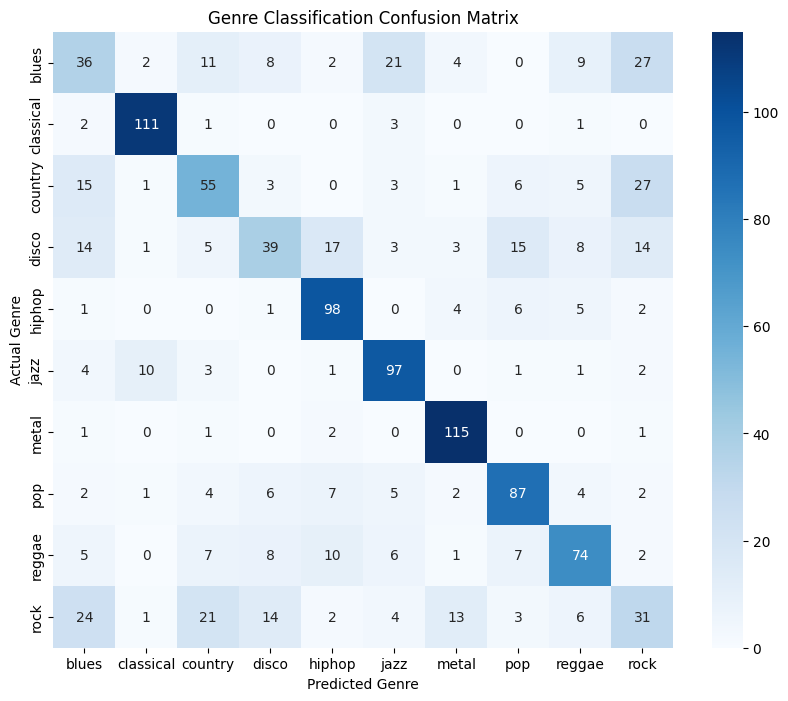

In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your saved model
model = load_model('/content/best_genre_model.keras')

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Genre")
plt.ylabel("Actual Genre")
plt.title("Genre Classification Confusion Matrix")
plt.show()

##VERY IMPRESSIVE RESULTS!!

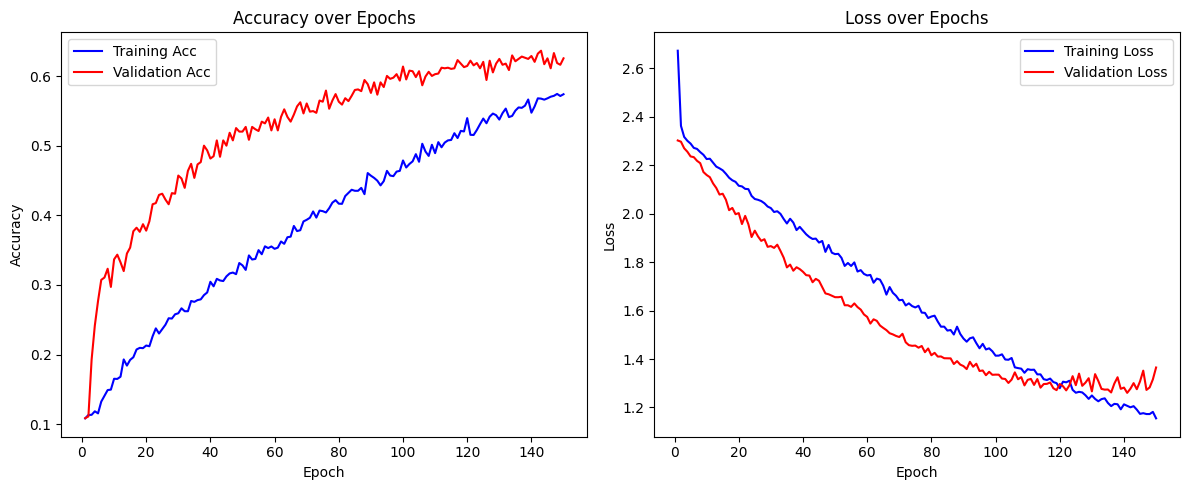

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Acc')
plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()